## Solution of a Driven Damped Pendulum using a Kolmogorov-Arnold Network (KAN)

***Author: Brandon Ismalej (brandon.ismalej.671@my.csun.edu) - (https://github.com/Brandon-Ism)***

In [64]:
!pip install pykan torch numpy matplotlib scikit-learn tqdm sympy setuptools

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
from torch import autograd
from kan import KAN
import math
import os

In [66]:
from sympy import symbols, Function
gamma_sym = symbols('gamma')
gamma_func = Function('gamma')

# Clear previous definitions
del gamma_sym
del gamma_func

In [67]:
# Initialize Constants
Omega_val = 2 * np.pi  
omega_val = Omega_val * 1.5 
lambda_val = omega_val / 2 
gamma_val = 1.2
omegaSQ_val = omega_val ** 2
f_val = gamma_val * omegaSQ_val

In [68]:
# This is the function for scipy odeint that helps it to solve the diff equation
# Differential equation
def helper(t, theta):
    theta, z = theta
    dthetadt = [z, f_val * math.cos(Omega_val * t) - omegaSQ_val * math.sin(theta) - lambda_val * z]
    return dthetadt

In [69]:
# Define the driven damped pendulum differential equation
#def driven_damped_pendulum(t, y, omega, lambda_, gamma, Omega):
#    theta, omega_dot = y
#   dydt = [omega_dot, -lambda_ * omega_dot - omega**2 * np.sin(theta) + gamma * np.cos(Omega * t)]
 #   return dydt

# Initial conditions
initial_conditions = [0, 0]
start_val = 0
end_val = 15

# Time points
t = np.linspace(start_val, end_val, 3000)

# Solve the differential equation using solve_ivp
sol = solve_ivp(helper, [start_val, end_val], initial_conditions, t_eval=t, method='LSODA', rtol=1e-6, atol=1e-8)

# Solve the differential equation using solve_ivp
# sol = solve_ivp(driven_damped_pendulum, [t[0], t[-1]], y0, args=(omega_val, lambda_val, gamma_val, Omega_val), t_eval=t, method='LSODA', rtol=1e-6, atol=1e-8)

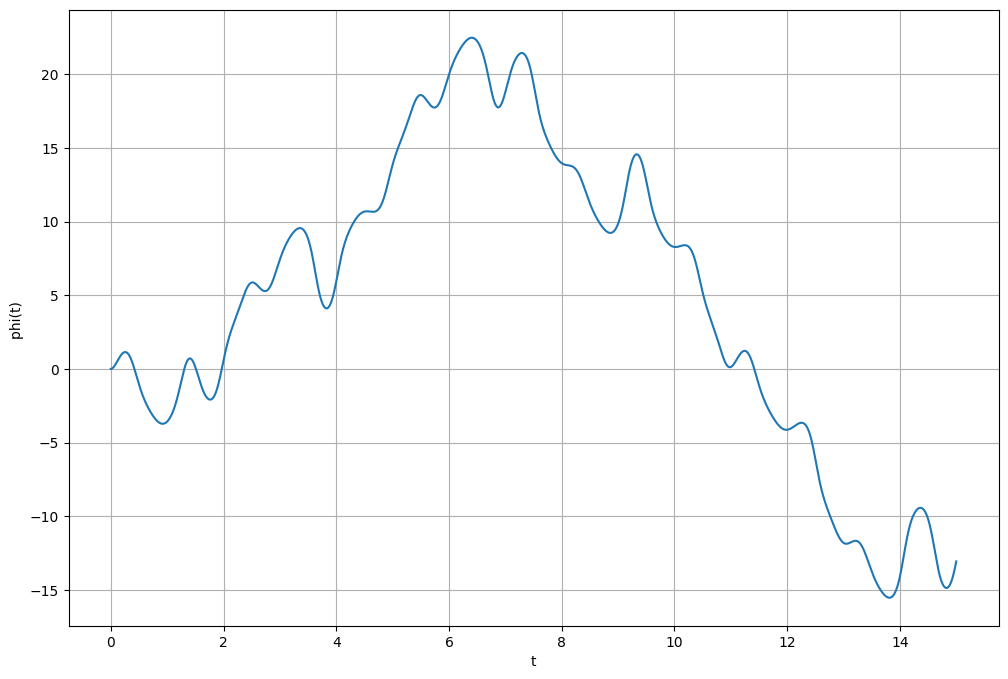

In [70]:
plt.figure(figsize=(12, 8))
plt.plot(sol.t, sol.y[0], label='Numerical Solution')
plt.xlabel('t')
plt.ylabel('phi(t) ')
plt.grid(True)
plt.savefig('numerical_only.png')
plt.show()

In [71]:
# Save ODE solver results to CSV
ode_df = pd.DataFrame({'t': sol.t, 'theta': sol.y[0], 'omega_dot': sol.y[1]})
ode_df.to_csv('ode_solver_results.csv', index=False)

In [72]:
# Define a separate time interval for the neural network training
nn_start_val = 0
nn_end_val = 5
nn_t = np.linspace(nn_start_val, nn_end_val, 15000)

# Prepare training data based on the new time interval
x_physics = torch.tensor(nn_t, dtype=torch.float32).view(-1, 1)
y_physics = torch.tensor(np.interp(nn_t, t, sol.y[0]), dtype=torch.float32).view(-1, 1)

In [73]:
print({type(x_physics)})

{<class 'torch.Tensor'>}


In [74]:
from kan import *

physics_weight = 1e-3

# Define the KAN model
model = KAN(width=[1,4,4,4,1], grid=5, k=3, seed=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()


checkpoint directory created: ./model
saving model version 0.0


In [75]:
# Convert to torch.Tensor
Omega = torch.tensor(Omega_val, dtype=torch.float32)
omega = torch.tensor(omega_val, dtype=torch.float32)
lambda_ = torch.tensor(lambda_val, dtype=torch.float32)
gamma = torch.tensor(gamma_val, dtype=torch.float32)  
omegaSQ = torch.tensor(omegaSQ_val, dtype=torch.float32)
f = torch.tensor(f_val, dtype=torch.float32)

In [76]:
# Training loop
epochs = 1000
losses = {'total_loss': [], 'boundary_loss': [], 'physics_loss': []}

for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(x_physics)
    
    # Compute boundary loss (initial condition)
    boundary_loss = criterion(outputs[0], torch.tensor([initial_conditions[0]], dtype=torch.float32))
    
    # For simplicity, we'll consider physics loss as the total loss in this context
    physics_loss = criterion(outputs, y_physics)
    
    # Total loss
    total_loss = boundary_loss + physics_loss
    total_loss.backward()
    optimizer.step()
    
    losses['total_loss'].append(total_loss.item())
    losses['boundary_loss'].append(boundary_loss.item())
    losses['physics_loss'].append(physics_loss.item())

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Total Loss: {total_loss.item():.4f}')


Epoch [100/1000], Total Loss: 2.3196
Epoch [200/1000], Total Loss: 0.4150
Epoch [300/1000], Total Loss: 0.2979
Epoch [400/1000], Total Loss: 0.2454
Epoch [500/1000], Total Loss: 0.2083
Epoch [600/1000], Total Loss: 0.1557
Epoch [700/1000], Total Loss: 0.1133
Epoch [800/1000], Total Loss: 0.0799
Epoch [900/1000], Total Loss: 0.0564
Epoch [1000/1000], Total Loss: 0.0413


In [77]:
# Print final losses
print("\nFinal Losses:")
print(f"Total Loss: {losses['total_loss'][-1]:.4f}")
print(f"Boundary Loss: {losses['boundary_loss'][-1]:.4f}")
print(f"Physics Loss: {losses['physics_loss'][-1]:.4f}")



Final Losses:
Total Loss: 0.0413
Boundary Loss: 0.0000
Physics Loss: 0.0413


In [78]:
# Save KAN loss values to CSV
loss_df = pd.DataFrame(losses)
loss_df.to_csv('kan_loss_values.csv', index=False)

In [79]:
# Predict using the KAN model
y_kan = model(x_physics).detach().numpy()
kan_df = pd.DataFrame({'t': nn_t, 'theta': y_kan.squeeze()})
kan_df.to_csv('kan_results.csv', index=False)

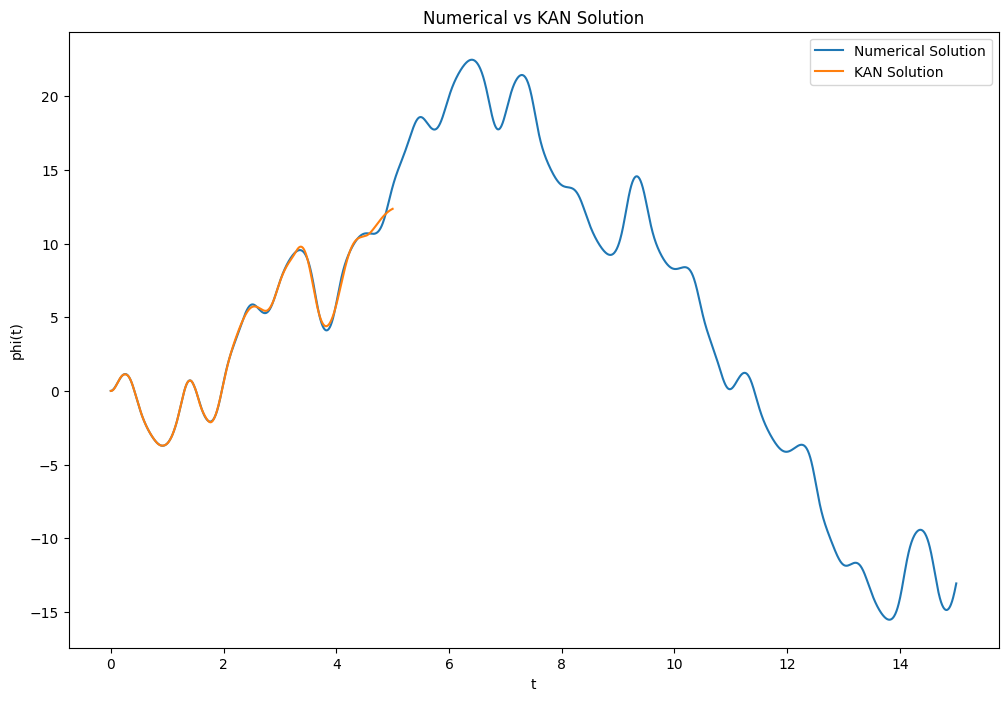

In [80]:
# Plot both the numerical and KAN solutions before pruning
plt.figure(figsize=(12, 8))  
plt.plot(sol.t, sol.y[0], label='Numerical Solution')
plt.plot(nn_t, y_kan, label='KAN Solution')
plt.xlabel('t')
plt.ylabel('phi(t)')
plt.legend()
plt.title('Numerical vs KAN Solution')


plt.savefig('/kaggle/working/KAN_vs_numerical.png')
plt.show()

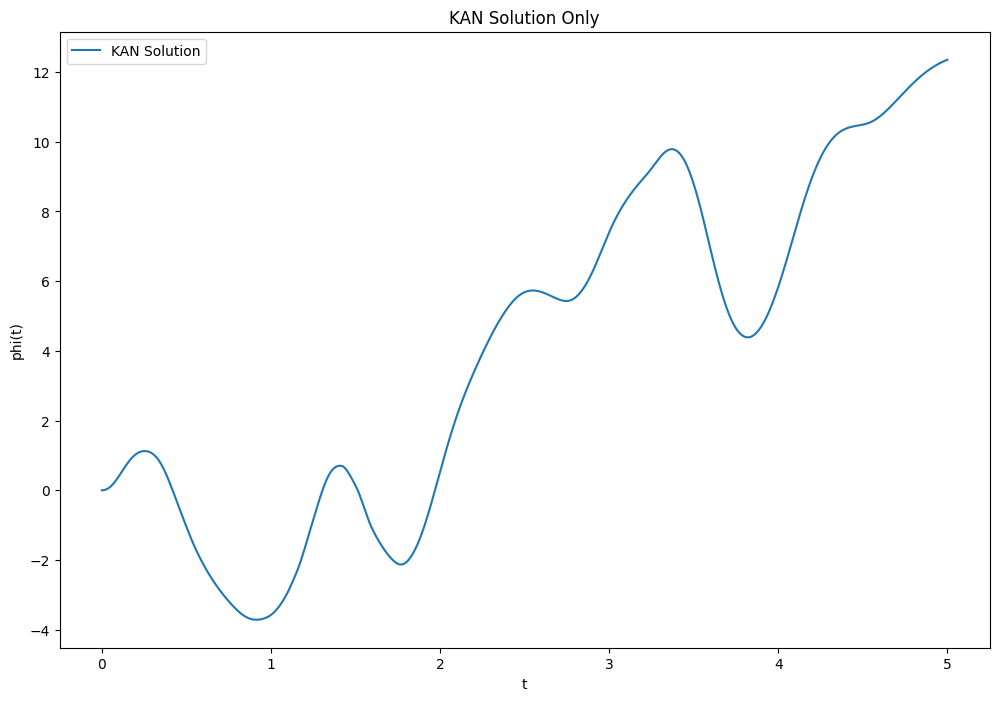

In [81]:
# Plot only the KAN solution before pruning
plt.figure(figsize=(12, 8))
plt.plot(nn_t, y_kan, label='KAN Solution')
plt.xlabel('t')
plt.ylabel('phi(t)')
plt.legend()
plt.title('KAN Solution Only')

plt.savefig('/kaggle/working/KAN_only.png')
plt.show()

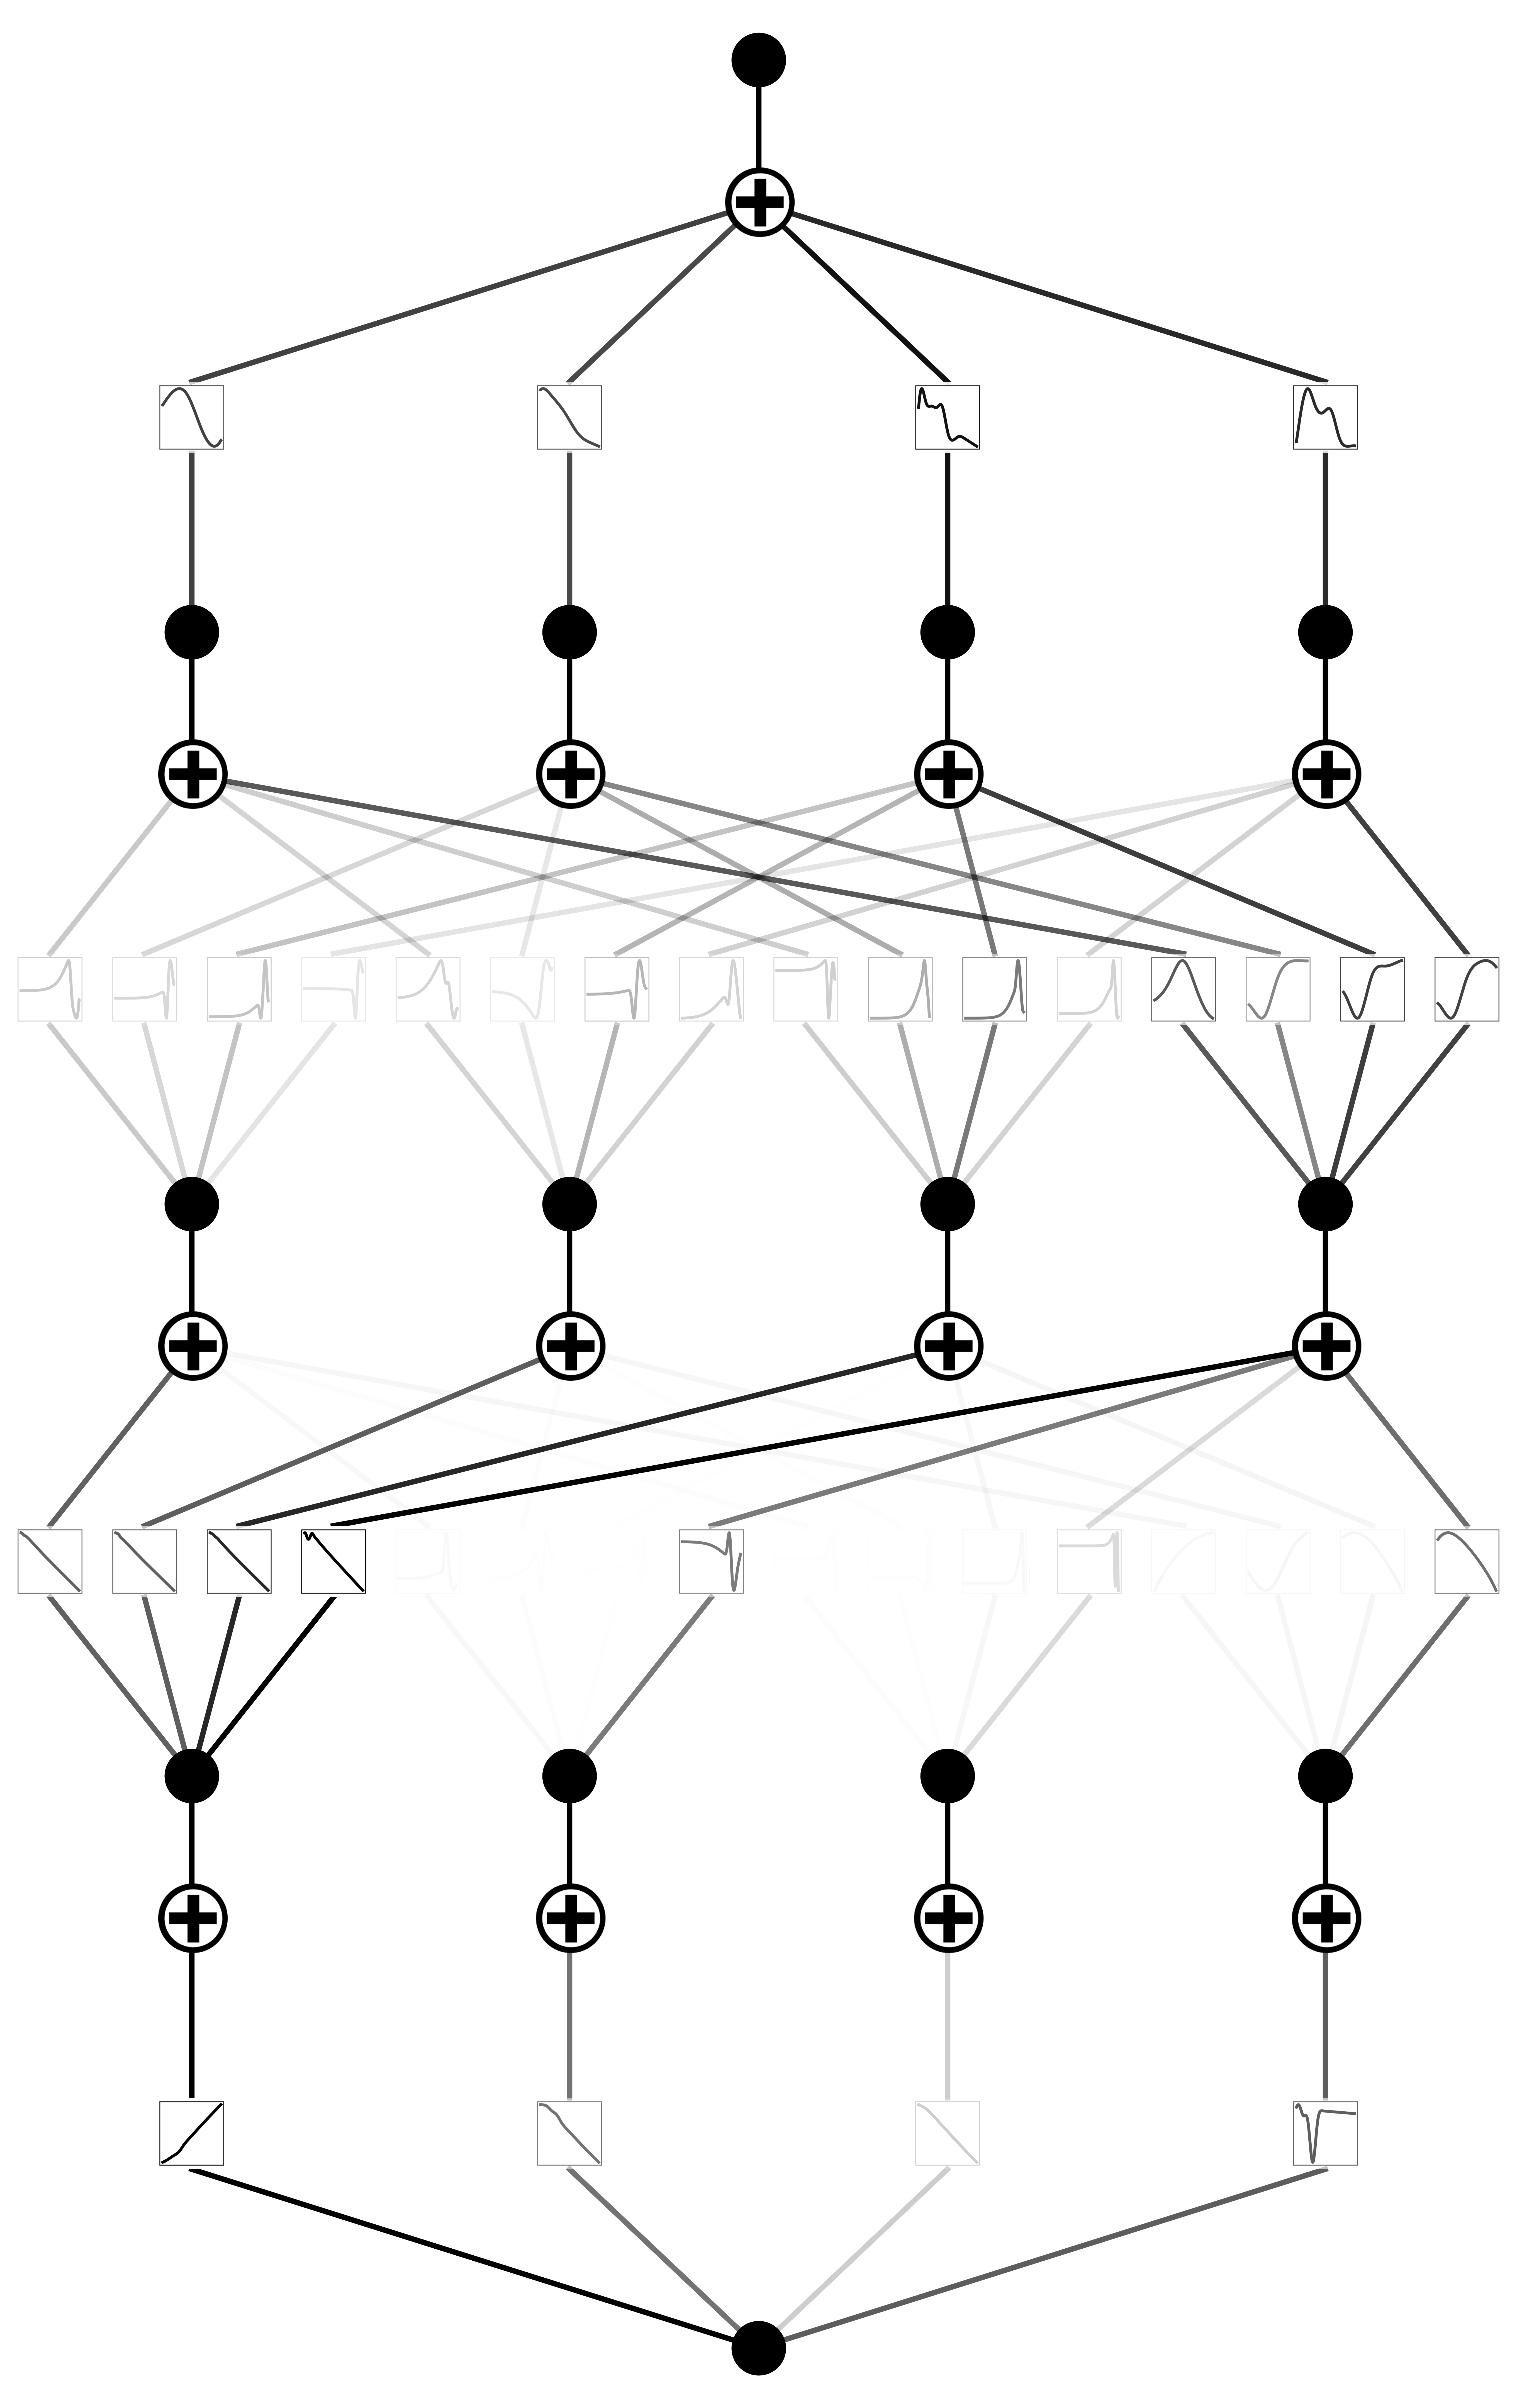

In [82]:
# Plot the KAN grid before pruning
model.plot(scale=7)
plt.savefig('/kaggle/working/KAN_before_prune.png')

saving model version 0.1


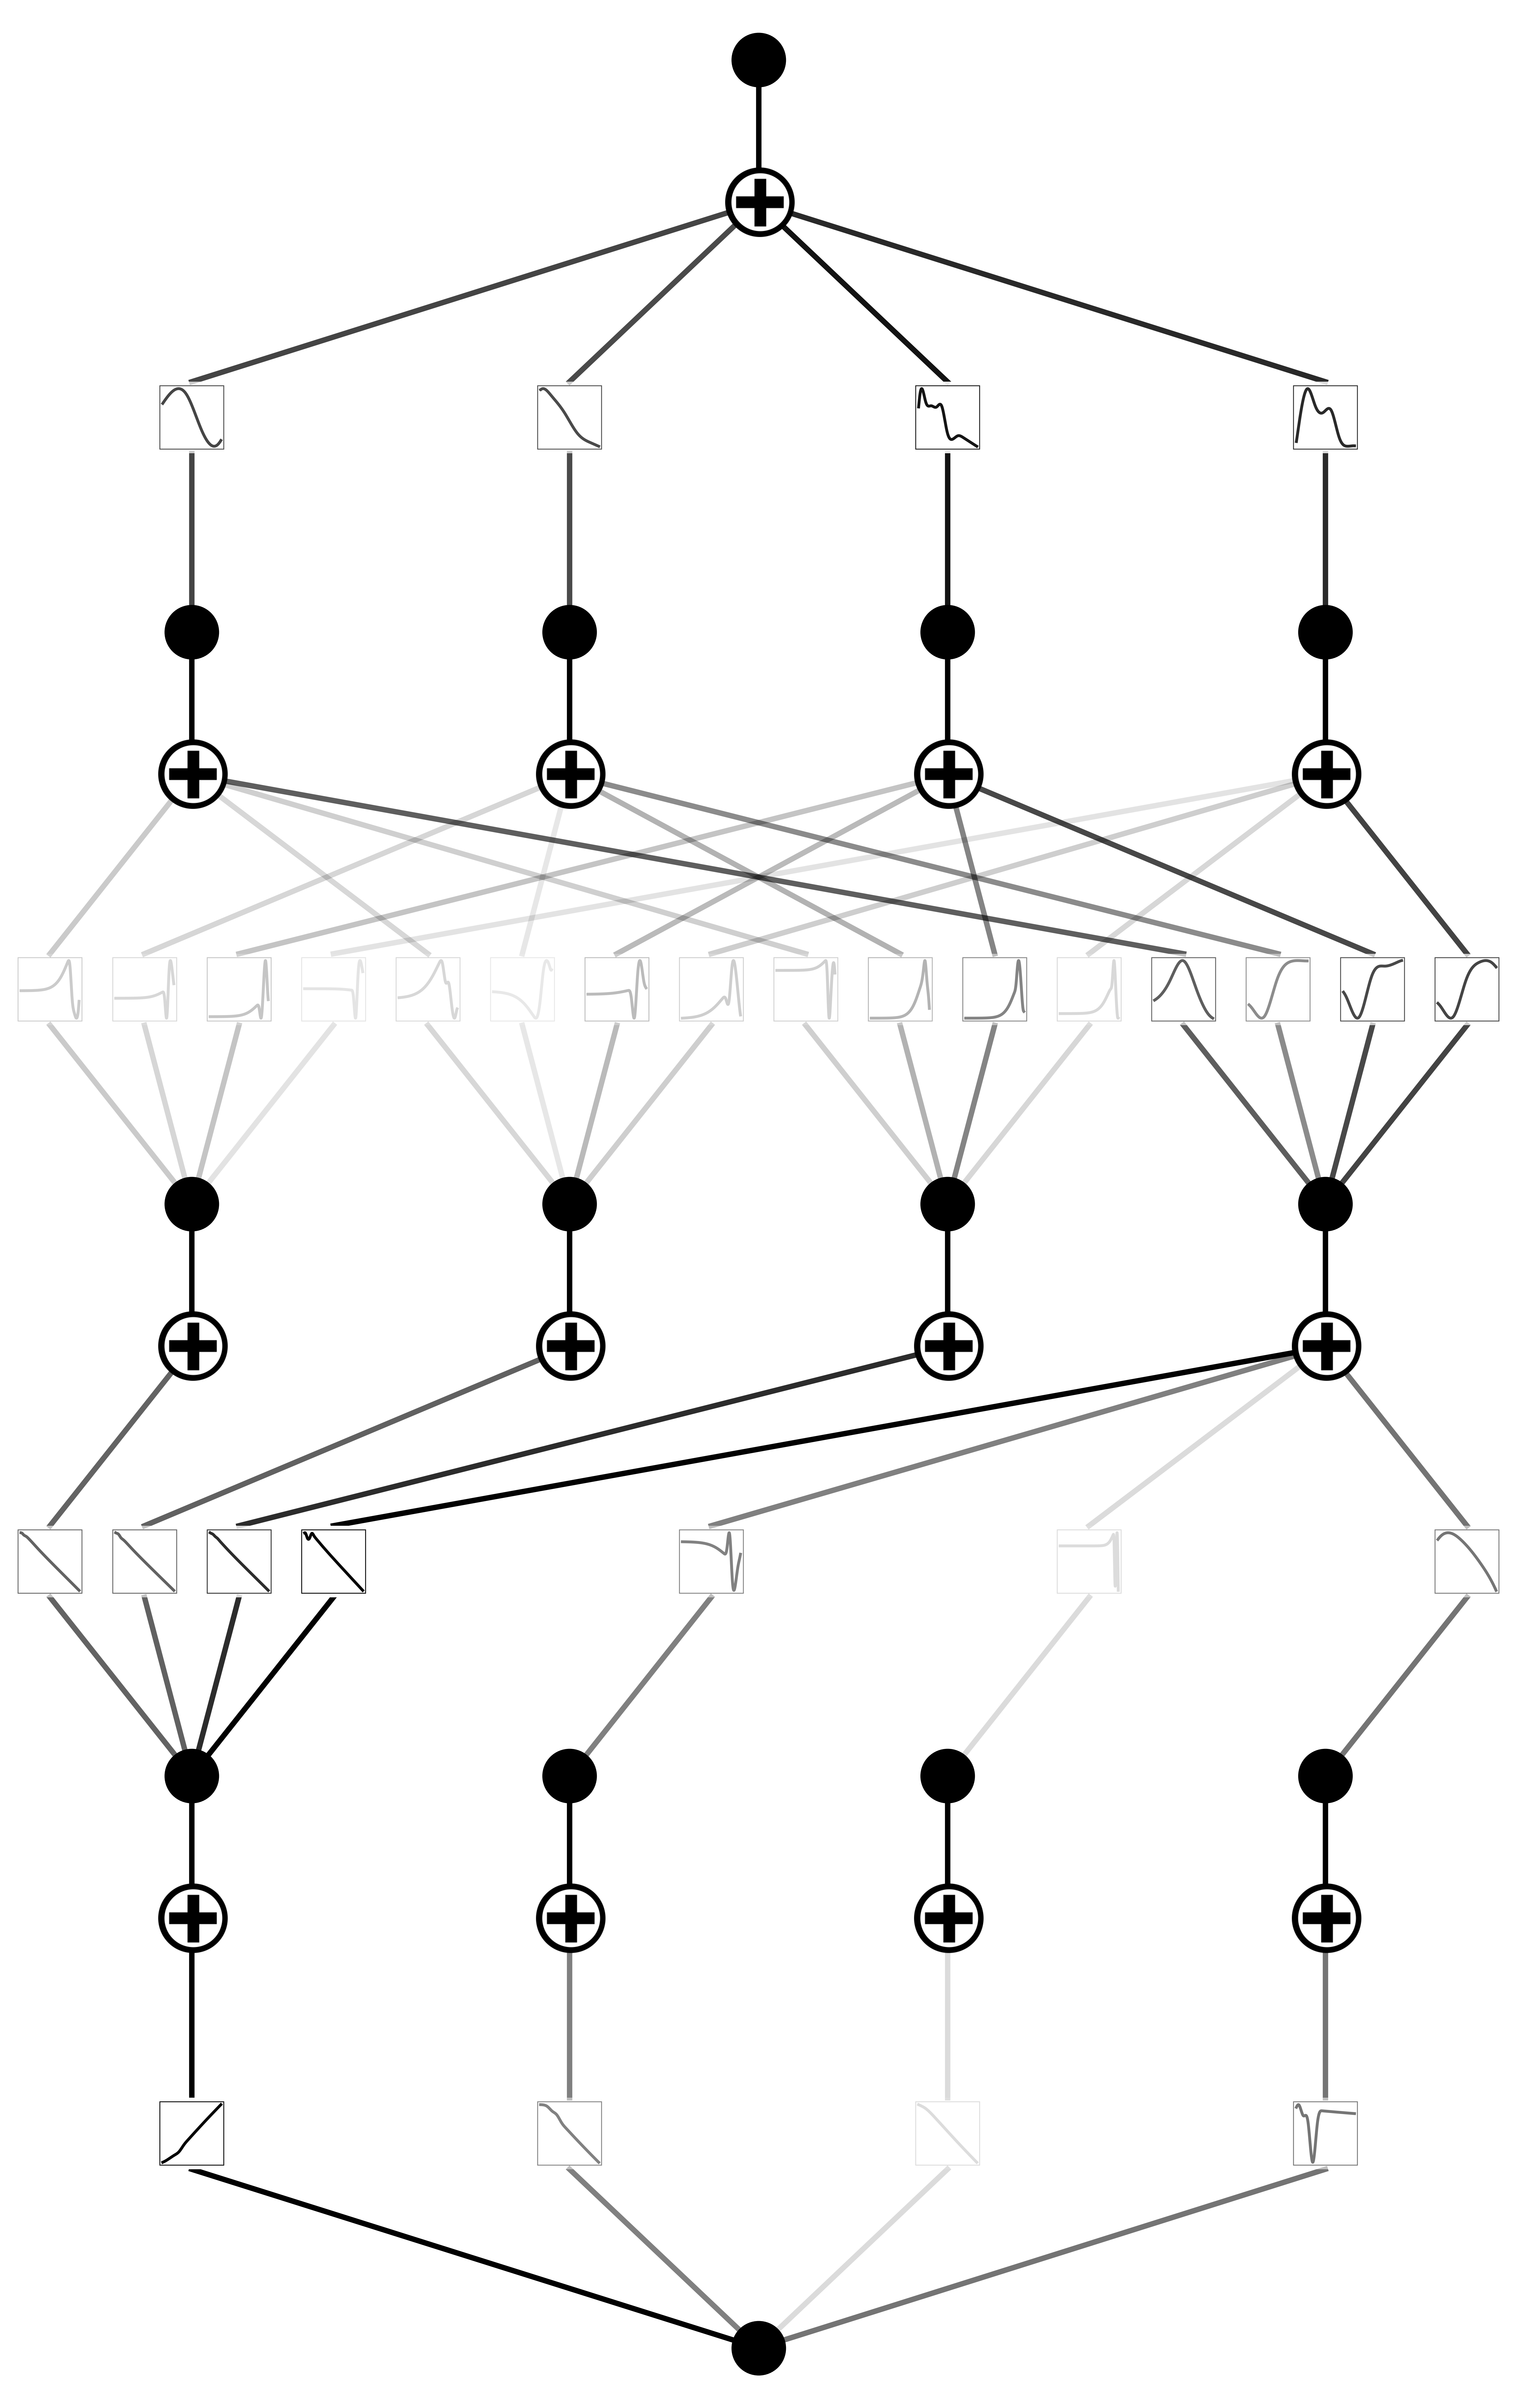

In [83]:
# Plot the KAN grid after automatic pruning
model_pruned=model.prune()
model_pruned(x_physics)
model_pruned.plot(scale=7)
plt.savefig('/kaggle/working/KAN_after_prune.png')

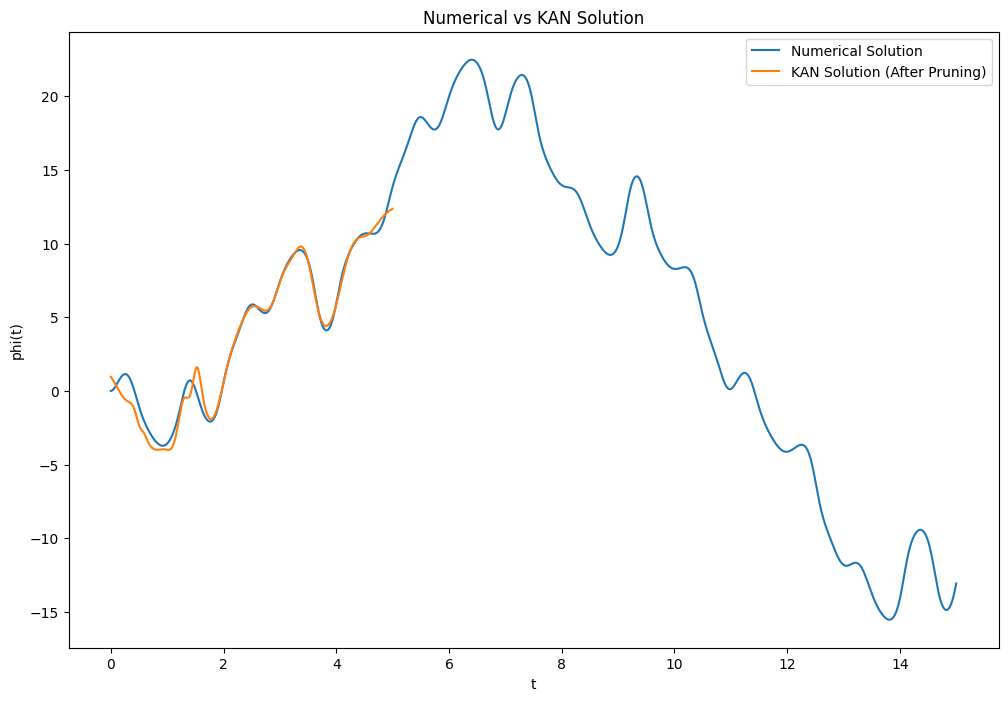

In [84]:
# Predict using the KAN model
y_kan_prune = model_pruned(x_physics).detach().numpy()
kan_df_prune = pd.DataFrame({'t': nn_t, 'theta': y_kan_prune.squeeze()})
kan_df_prune.to_csv('kan_results_pruned.csv', index=False)

# Plot both the numerical and KAN solutions (KAN after pruningsdx)
plt.figure(figsize=(12, 8))  
plt.plot(sol.t, sol.y[0], label='Numerical Solution')
plt.plot(nn_t, y_kan_prune, label='KAN Solution (After Pruning)')
plt.xlabel('t')
plt.ylabel('phi(t)')
plt.legend()
plt.title('Numerical vs KAN Solution')
plt.savefig('/kaggle/working/KAN_vs_numerical.png')
plt.show()

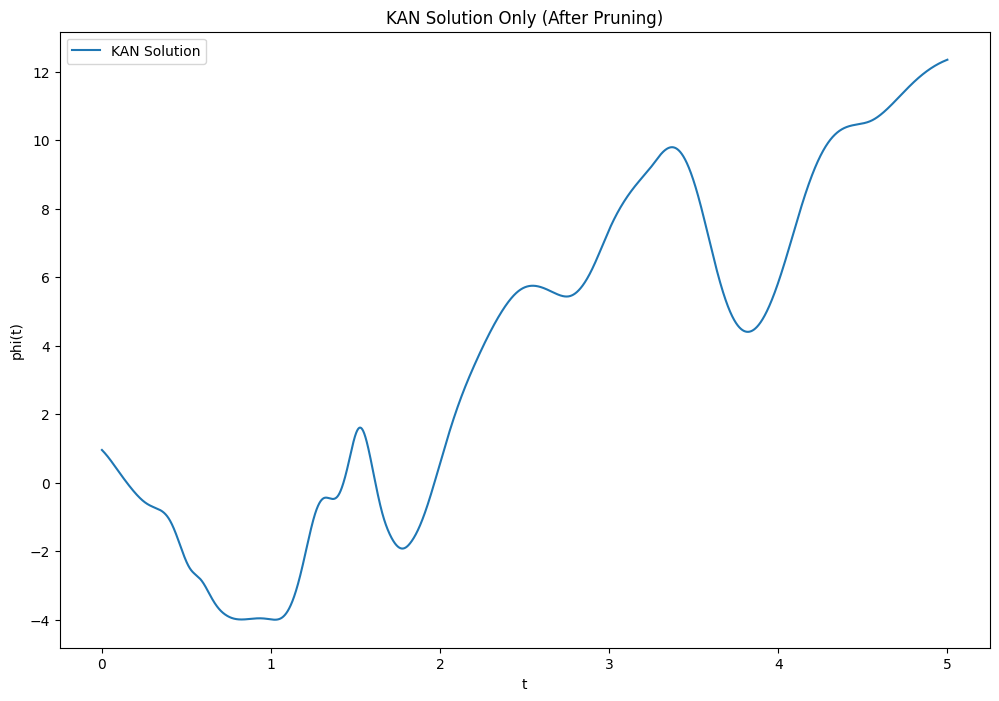

In [85]:
# Plot only the KAN solution after pruning
plt.figure(figsize=(12, 8))
plt.plot(nn_t, y_kan_prune, label='KAN Solution')
plt.xlabel('t')
plt.ylabel('phi(t)')
plt.legend()
plt.title('KAN Solution Only (After Pruning)')
plt.savefig('/kaggle/working/KAN_only.png')
plt.show()